# OHM Bond Volatility Research

## Summary

The research aims to discern the drivers of system volatility as it relates to bond release. Different parameterizations of bond release are studied to determine the main effects.

## Experimental Set Up/Parameters

For each of the experiments below, there is a separate experimental set up described.

## KPIs

The following KPIs are measured in the experiments:

- Price volatility: the standard deviation of day-to-day price change percentage
- Probability of pool drainage: in extreme cases, pools may get drained out because of large amount of buy / sell stimulated by the bond issuance / expiration.

# Experiment 1 - Release Date Distribution Effect

## Experimental Setup

- The simulations are generally run with the normal parameters
- The bond scheduling is the change applied in this experiment
- There are three sets of bond release schedules and two levels of total face value which are compared against one and other

## Parameter Sweep

- total_face_value: The total amount of face value attributed to the bond release
    - Values are 2e6 and 5e6
- bond_value_distribution: The distribution between the values for each bond distribution. The larger the number, the higher the share of the total face value that is released at that given date.
    - Values are [1, 1, 1], [2, 1, 1], [4, 1, 1]

In [ ]:
import sys
sys.path.append("../..")

from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
from model.utility.default_initial_state import default_initial_state1 as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run,new_run, post_processing
import pandas as pd


# Create the different bonds
bonds = []
bond_schedule_name = []

# start with an empty bond -- no ohm bonds
bonds.append(pd.DataFrame([], columns=['start_days', 'bonds']))
bond_schedule_name = ['No Bond']

# Universal Bond Params
start_dates = [10,30,50]
bond_tenors = 30

# Run parameters
number_runs = 10
number_steps = 100

# Equal value release bond
for distribution in [[1,1,1],[2,1,1],[4,1,1]]:
    for name,total_face_value in {'Med':2e6,'Lrg':5e6}.items():
        bonds.append(total_value_bond_creation(start_dates= start_dates,
                                  simulation_timesteps=number_steps,
                                  bond_tenors=bond_tenors,
                                  total_face_value=total_face_value,
                                  bond_value_distribution=distribution))
        bond_schedule_name.append("{0}/{1}/{2} ".format(*distribution)+name)

params.update({'bond_create_schedule':bonds})
params.update({'bond_schedule_name':bond_schedule_name})

# Fill in the initial state
initial_state = fill_in_initial_state(initial_state, params)

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
df1a = post_processing(raw)
df1a.to_csv("bond_research_runs1a.csv")


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 70, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 70, 69)
Execution Method: local_simulations
Execution Mode: parallelized


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")

df1 = pd.read_csv("bond_research_runs1a.csv", index_col=0)
number_steps = 100

### KPIs and Success Metrics

In [2]:
df1["bond_schedule_name"] = df1["bond_schedule_name"].fillna(method='bfill')

# Get the amount that front loading was favored
df1["front_load_amount"] = df1["bond_schedule_name"].apply(lambda x: x[0]).map({"1":1,"2":2,'4':4,'N':0})

# Get face value in e6 terms
df1["face_value"] = df1["bond_schedule_name"].apply(lambda x: x.split(" ")[-1]).map({"Med": 2,
                                                                "Lrg": 5, "Bond":0})
std = df1.groupby("unique_id").apply(lambda x: x['price'].pct_change().std())
std.name = "price_volatility"


from model.utility.panic_sell_metrics import fun_pooldrained
pooldrained = fun_pooldrained(df1)
pooldrained=pd.Series(pooldrained,index = df1.unique_id.unique())
pooldrained.name = 'pool_drained_probability'

descriptors = df1.groupby("unique_id")[['front_load_amount',
 'face_value',]].last()
kpis = pd.concat([std,pooldrained, descriptors], axis=1)

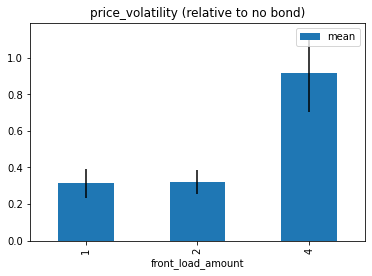

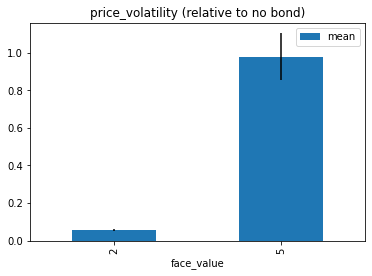

In [3]:
from model.utility.ohmbond_metrics import plot_relative_kpi
kpi = 'price_volatility'
plot_relative_kpi(kpi,kpis,descriptors)

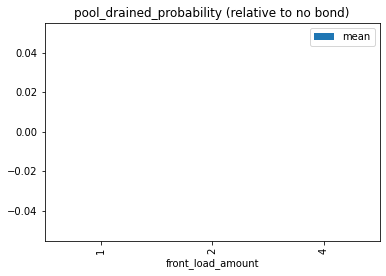

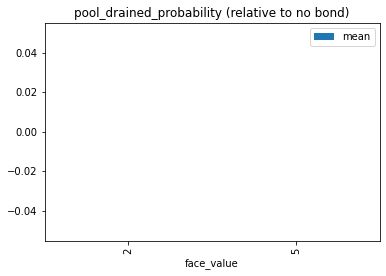

In [4]:
kpi = 'pool_drained_probability'
plot_relative_kpi(kpi,kpis,descriptors)

No pool drainage happened, so for this experiment we will ignore this kpi.

## Quantitative Feature Analysis
We use the decision tree as well as random forest regression to understand the importance of features

In [5]:
def tree_regression_analysis(df,xnames:list,yname:str):
    from sklearn.tree import DecisionTreeRegressor,plot_tree
    # fit the tree
    X = kpis[xnames]
    y = kpis[yname]
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X, y)
    # plot the tree
    fig,ax = plt.subplots(figsize = (15,6))
    plot_tree(tree,
              rounded=True,
              proportion=True,
              fontsize=8,
              feature_names=X.columns,
              class_names=['High Volatility', 'Reasonable Volatility'],
              filled=True,ax=ax)
    
    ax.set_title(f'Decision tree, score: {tree.score(X, y) :.0%}. N: {len(X) :.2e}')
              


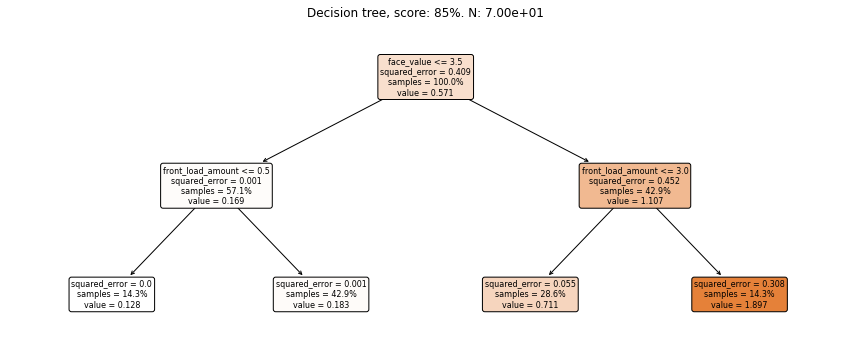

In [6]:
kpi = 'price_volatility'
tree_regression_analysis(df1,['front_load_amount','face_value',],kpi)

In [7]:
def randomforest_regression_analysis(df,xnames:list,yname:str):
    from sklearn.ensemble import RandomForestRegressor
    # fit model
    X = kpis[xnames]
    y = kpis[yname]
    rf = RandomForestRegressor()
    rf.fit(X, y)
    importance = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                        columns=['features', 'importance'])
            .sort_values(by='importance', ascending=False)
            )
    
    # plot the feature importance
    import seaborn as sns
    fig,ax = plt.subplots(figsize = (15,6))

    sns.barplot(data=importance,
                    x=importance.features,
                    y=importance.importance,
                    ax=ax,
                    label='small')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.set_title(f'Feature Importance')
    



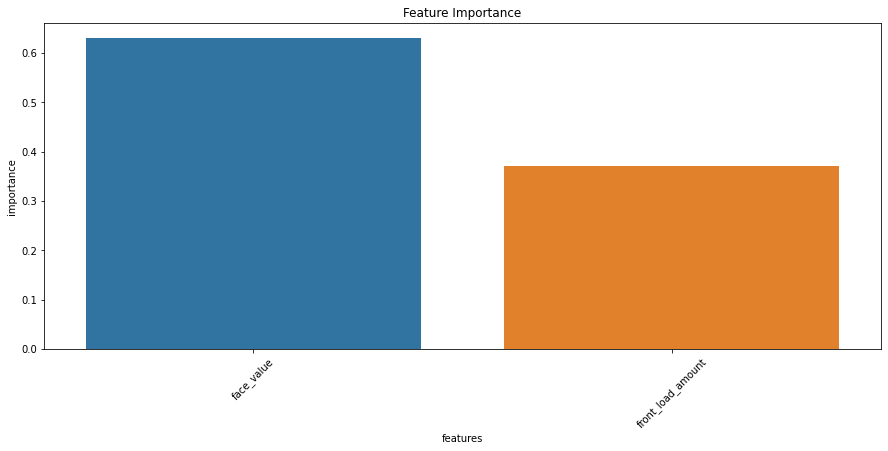

In [8]:
kpi = 'price_volatility'
randomforest_regression_analysis(df1,['front_load_amount','face_value',],kpi)

To conclude: in the current settings, having bonds will increase the price volatility compared to no bonds. The volatility is mainly driven by the face value, less so by the front_load_amount.

However this conclusion is constrained by the fact we didn't use overly large total_amount for bonds. In the next experiment, we would want to explore a larger range for the variable of bond total amount as well as changing the tenor of bonds (i.e. same starting dates, different release dates).

# Experiment 2: different distribution of bond amount regarding different tenors

In [ ]:
import sys
sys.path.append("../..")

from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
from model.utility.default_initial_state import default_initial_state1 as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run,new_run, post_processing
import pandas as pd

# Create the different bonds
bonds = []
bond_schedule_name = []

# start with an empty bond -- no ohm bonds
bonds.append(pd.DataFrame([], columns=['start_days', 'bonds']))
bond_schedule_name = ['No Bond']

# Universal Bond Params
start_dates = [10]
bond_tenors = [30,60,90]

# Run parameters
number_runs = 16
number_steps = 100

# Equal value release bond
for distribution in [[1,1,1],[2,1,1],[4,1,1]]:
    for name,total_face_value in {'Med':2e6,'Lrg':5e6,'XLrg':8e6}.items():
        bonds.append(total_value_bond_creation(start_dates= start_dates,
                                  simulation_timesteps=number_steps,
                                  bond_tenors=bond_tenors,
                                  total_face_value=total_face_value,
                                  bond_value_distribution=distribution))
        bond_schedule_name.append("{0}/{1}/{2} ".format(*distribution)+name)

params.update({'bond_create_schedule':bonds})
params.update({'bond_schedule_name':bond_schedule_name})

# Fill in the initial state
initial_state = fill_in_initial_state(initial_state, params)

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)



# Parse the raw data
df2 = post_processing(raw)
df2.to_csv("bond_research_runs2.csv")



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 160, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 160, 69)
Execution Method: local_simulations
Execution Mode: parallelized


## Analysis on Experiment 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")

df2 = pd.read_csv("bond_research_runs2.csv", index_col=0)
number_steps = 100

### Features and KPIs

In [2]:
df2["bond_schedule_name"] = df2["bond_schedule_name"].fillna(method='bfill')

# Get the amount that front loading was favored
df2["front_load_amount"] = df2["bond_schedule_name"].apply(lambda x: x[0]).map({"1":1,"2":2,'4':4,'N':0})

# Get face value in e6 terms
df2["face_value(e6)"] = df2["bond_schedule_name"].apply(lambda x: x.split(" ")[-1]).map({"Med": 2,
                                                                "Lrg": 5, 'XLrg':8,"Bond":0})

df2["max_single_bond_value(e6)"] =(df2["face_value(e6)"]*df2["front_load_amount"]/(2+ df2["front_load_amount"])).round(1)


std = df2.groupby("unique_id").apply(lambda x: x['price'].pct_change().std())
std.name = "price_volatility"


from model.utility.panic_sell_metrics import fun_pooldrained
pooldrained = fun_pooldrained(df2)
pooldrained=pd.Series(pooldrained,index = df2.unique_id.unique())
pooldrained.name = 'pool_drained_probability'

descriptors = df2.groupby("unique_id")[['front_load_amount',
 'face_value(e6)','max_single_bond_value(e6)']].last()
kpis = pd.concat([std,pooldrained, descriptors], axis=1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


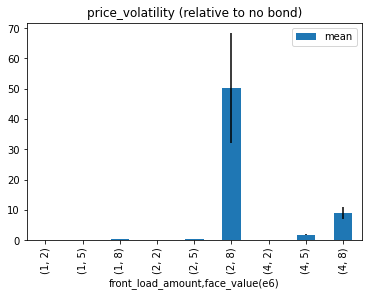

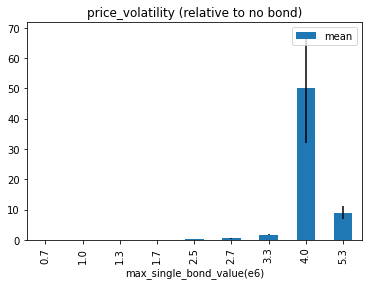

In [3]:
from model.utility.ohmbond_metrics import plot_relative_kpi
kpi = 'price_volatility'
plot_relative_kpi(kpi,kpis,descriptors,group_vars=[['front_load_amount','face_value(e6)'],'max_single_bond_value(e6)'])

Let's also add the log plot to better see the variation

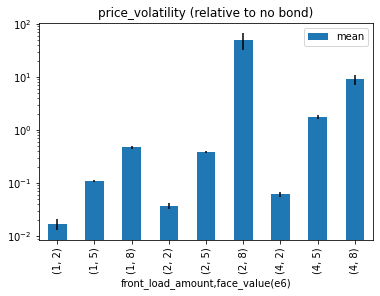

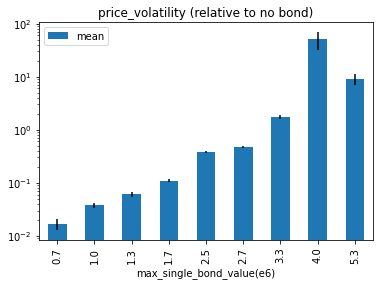

In [12]:
plot_relative_kpi(kpi,kpis,descriptors,group_vars=[['front_load_amount','face_value(e6)'],'max_single_bond_value(e6)'],log_y=True)

Here's a surprising observation: with a relatively large total face value (8e6), the medium level of front load (2:1:1) actually shows higher volatility. This, however, may be an unfair representation of the data because 100% of the combinations with high front load/high face value are simulations that terminates early due to the pool draining.

The time after bond disbursements would be one of higher volatility possibly, but becaues the simulation ends early, they are not included in the calculation of standard deviation. For that reason, we can consider them to be a source of bias.

This pool draining probability is shown below:

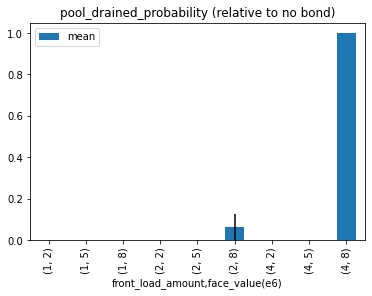

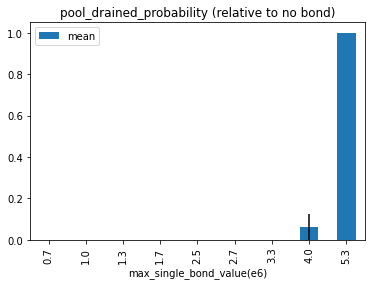

In [13]:
kpi = 'pool_drained_probability'
plot_relative_kpi(kpi,kpis,descriptors,group_vars=[['front_load_amount','face_value(e6)'],'max_single_bond_value(e6)'])

In the following analysis of price volatilty we will be careful with the high face value scenarios because of the high pool drainage rate. A future alternative is to exclude the runs that terminate early. This may also present a bias in the results though (artificially lowering the price volatility?).

## Quantitative feature analysis

In [14]:
from model.utility.visualization import tree_regression_analysis,randomforest_regression_analysis

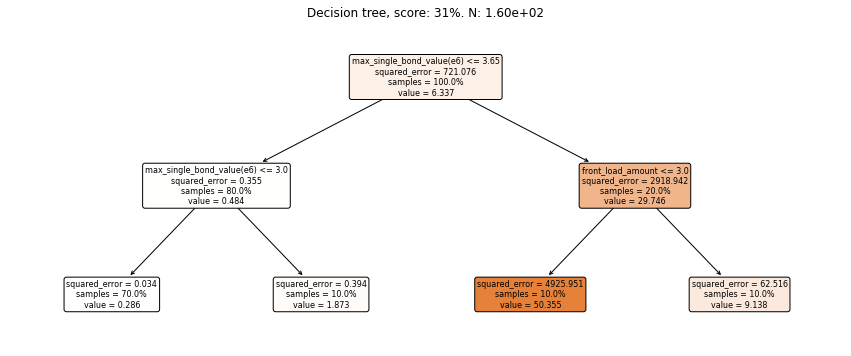

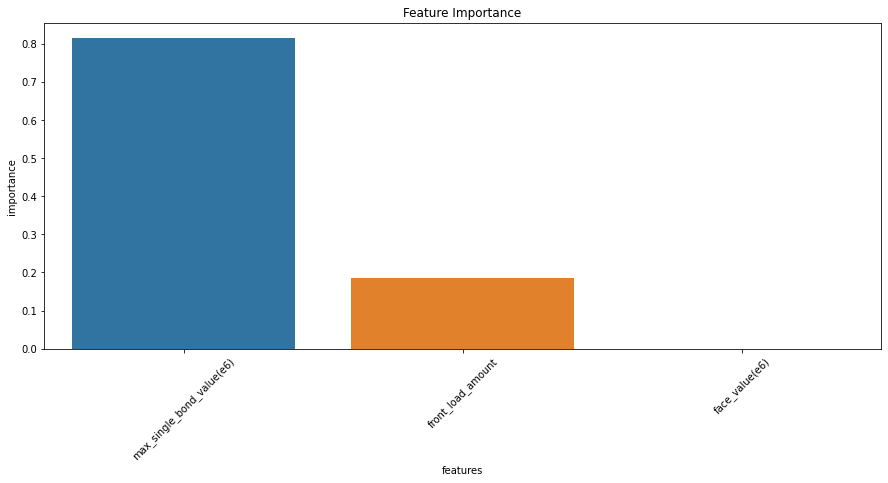

In [15]:
kpi = 'price_volatility'
tree_regression_analysis(kpis,descriptors.columns,kpi,tree_depth = 2)
randomforest_regression_analysis(kpis,descriptors.columns,kpi)

For volatility, the model fitting score does not have a high level of accuracy (25% in decision tree model), thus the feature importance analysis is not very reliable either. This is because of how now with higher face value compared to experiment 1, the high face_value, high front_load situation will actually drain the pool rather than pushing up the price volatility, therefore adding noise to the easier monotomic relation between the features and the kpi.

To address that, we do the price volatility analysis for lower face values so the pool drainage is not an interferring issue, as below:

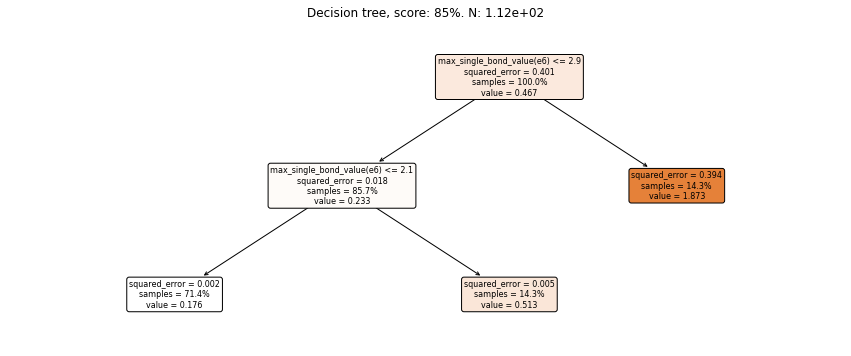

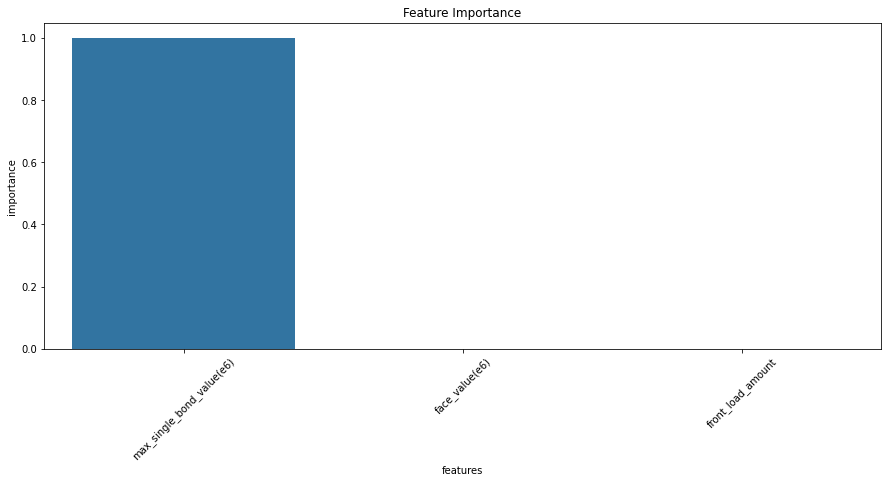

In [16]:
kpi = 'price_volatility'
subkpi_df = kpis.loc[kpis['face_value(e6)']<8]
tree_regression_analysis(subkpi_df,descriptors.columns,kpi,tree_depth = 2)
randomforest_regression_analysis(subkpi_df,descriptors.columns,kpi)

Excluding the extremely large face value, we see the max_single_bond_value is the most important feature that is positively correlated with price volatility.

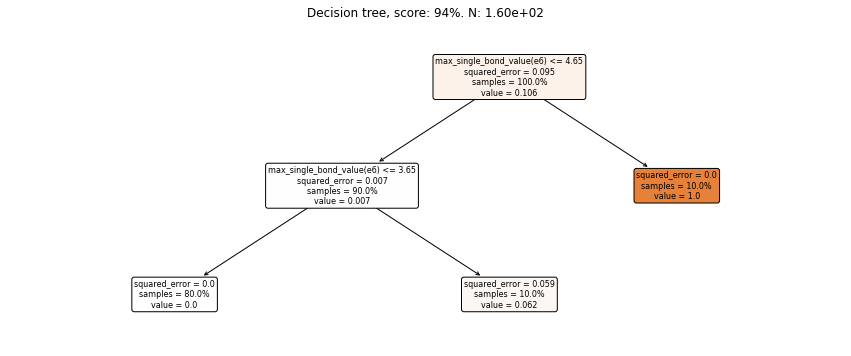

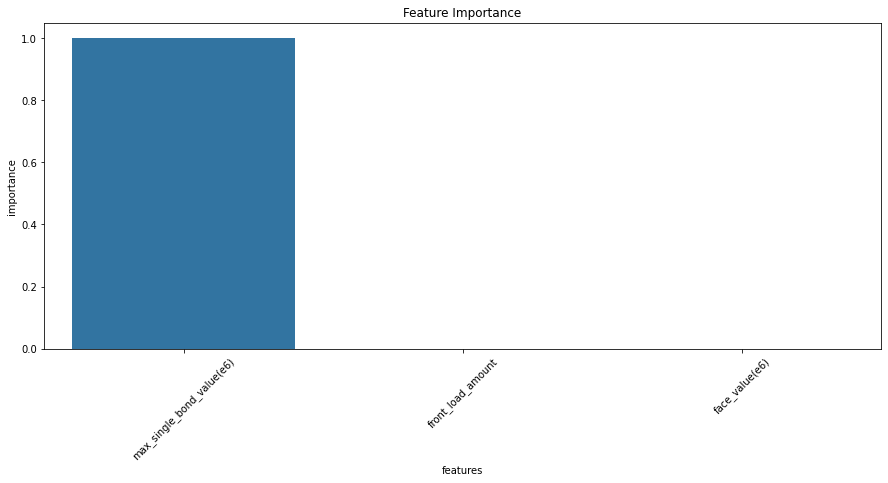

In [17]:
kpi = 'pool_drained_probability'

tree_regression_analysis(kpis,descriptors.columns,kpi,tree_depth=2)
randomforest_regression_analysis(kpis,descriptors.columns,kpi)

The max value of a single bond is clearly the most significant factor regarding how likely the issuance of ohm bond will drain the pool.

### how does pool drainage happen?

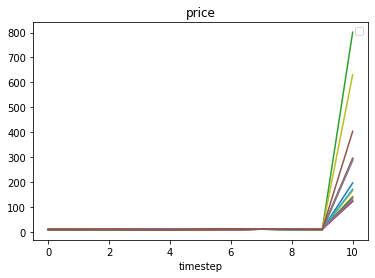

In [4]:
from model.utility.visualization import plot_all_sims
# plot all simulations of Extra large total face value and 4-1-1 front load
plot_all_sims(['price'],df2.loc[(df2["face_value(e6)"]==8)*(df2["front_load_amount"]==4)])

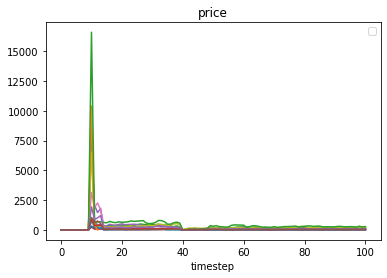

In [5]:
from model.utility.visualization import plot_all_sims
# plot all simulations of Extra large total face value and 4-1-1 front load
plot_all_sims(['price'],df2.loc[(df2["face_value(e6)"]==8)*(df2["front_load_amount"]==2)])

All the drainage happens when the bond is issued and we assume people pool a significant amount of OHM out of the liquidity pool to buy bonds, causing the pool to drain. This is indicating that the bond is too big for the pool depth, especially given now all 3 bonds are issued at the same day. 

# Conclusion from Experiment 1 & 2

In Experiment 1 we explored different starting dates of different bonds and varying the face value of the bonds. We found that face value contributes more to the price volatility than the ratio of each bond's value distribution. The use of bonds overall will cause more price volatility than without bonds.

In Experiment 2 we explored different tenors of bonds with the same starting dates and a varying amount of face value, this time also adding more extreme ranges of high bond face values. We found that for really high face value (8e6 in this case) it's much more likely to drain the pool. In a more reasonable face value range, we also introduced the alternative feature of "max_single_bond_value" which predicts the price volatility well.

For future studies, the following other factors could be looked into:
- the impact factor from bond to netflow
- overall market activity volatility (the randomization of netflow)
- contrasting the results with and without RBS 